In [2]:
# PACKAGE IMPORTS

# special IPython command to prepare the notebook for matplotlib
%matplotlib inline 

import requests
import io
import numpy as np
import pandas as pd # pandas
import matplotlib.pyplot as plt # module for plotting
import datetime as dt # module for manipulating dates and times
import numpy.linalg as lin # module for performing linear algebra operations
import zipfile


**Data description**

	
- pclass	Ticket class (proxy for SES)
- sex	Sex	
- Age	Age in years. Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp	# of siblings / spouses aboard the Titanic. Sibling = brother, sister, stepbrother, stepsister. Spouse = husband, wife (mistresses and fiancés were ignored)
- parch	# of parents / children aboard the Titanic. Parent = mother, father. Child = daughter, son, stepdaughter, stepson. Some children travelled only with a nanny, therefore parch=0 for them.
- ticket	Ticket number	
- fare	Passenger fare	
- cabin	Cabin number	
- embarked	Port of Embarkation

In [3]:
path='C:/Users/Baptiste/Documents/Python Scripts/train.csv'
path_test='C:/Users/Baptiste/Documents/Python Scripts/test.csv'

df=pd.read_csv(path)
df_test=pd.read_csv(path_test)
print(df.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [4]:
#seperate ticket number into a string and a number

ticket_tuples=df['Ticket'].str.split(' ')
digits=pd.Series(ticket_tuples.str[1])
string=pd.Series(ticket_tuples.str[0])

for i in range(0,digits.shape[0]):
    if(digits[i]!=digits[i]):
        digits[i]=string[i]
        string[i]=0
    if(digits[i]=="LINE"):
        digits[i]=0
    if(digits[i]=="Basle"):
        digits[i]=0

df['Ticket']=pd.to_numeric(digits)
df['Ticket_str']=string


In [5]:
import warnings
warnings.filterwarnings('ignore')

#Create cabin letter and numbers - basic splitting into letter/number
df['Cabin_letter']=df['Cabin'].str.slice(0,1)
df['Cabin_number']=df['Cabin'].str.slice(1)

#second split (some cabin letters are malformed)
ticket_tuples=df['Cabin'].str.split(' ')
subset=pd.Series(ticket_tuples.str[1])
subset2=subset.str.slice(start=1)
sub=df.loc[subset2.notnull()]
sub3=np.transpose(np.array([subset2.isnull()]))

for n in range(sub3.shape[0]):
    if (not sub3[n]):
        df['Cabin_number'][n]=subset2[n]

df['Cabin_number']=df['Cabin_number'].fillna(0)

for n in range(df['Cabin_number'].shape[0]):
    value=df['Cabin_number'][n]
    try:
        value = int(value)
    except ValueError:
        df['Cabin_number'][n]=0

df['Cabin_number']=df['Cabin_number'].astype(int)
df=df.fillna(30)


In [6]:
discrete=['Pclass', 'Name', 'Sex', 'Ticket_str', 'Cabin', 'Embarked', 'Cabin_letter']
continuous=['Age', 'Fare', 'SibSp', 'Parch', 'Ticket', 'Cabin_number']
predict=['Survived']


**Simple data exploration continuous variables**

- Set missing values to -20 to clearly visualize distribution. No fares or SibSp/Parch missing, 20% of ages missing (correlated with SES?)
- Mean fare 32 but high standard dev -> signs high inequality on board
- Age isn't normally distributed - unit distribution till 20, then large increase. Could create cat variable for children
- If look closely, fare has double distribution: few observations around 50

Age
Fare
SibSp
Parch
Ticket
Cabin_number


,Age,Fare,SibSp,Parch,Ticket,Cabin_number
count,891.000000,891.000000,891.000000,891.000000,8.910000e+02,891.000000
mean,29.758889,32.204208,0.523008,0.381594,2.552204e+05,11.384961
std,13.002570,49.693429,1.102743,0.806057,5.694927e+05,26.986450
min,0.420000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,22.000000,7.910400,0.000000,0.000000,1.351850e+04,0.000000
50%,30.000000,14.454200,0.000000,0.000000,1.108130e+05,0.000000
75%,35.000000,31.000000,1.000000,0.000000,3.470735e+05,0.000000
max,80.000000,512.329200,8.000000,6.000000,3.101317e+06,148.000000


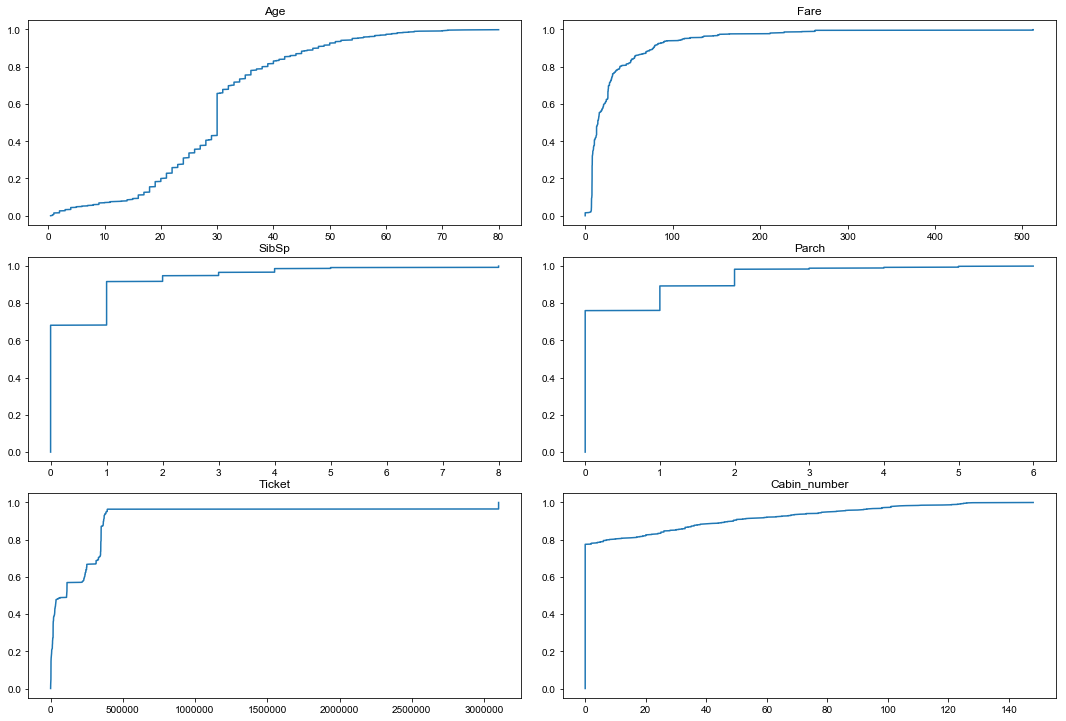

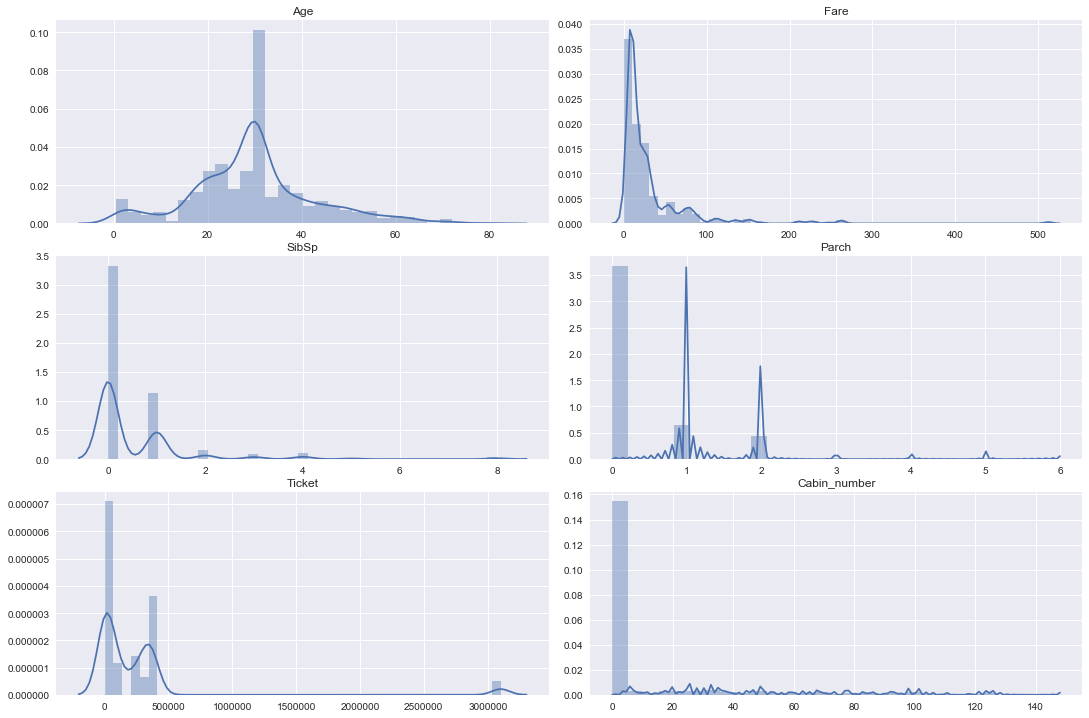

In [7]:
fig, axs = plt.subplots(3,2, figsize=(15,10))
fig.tight_layout()

for ax,i in zip(axs, range(3)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        print(column)
        sorted=np.sort(df[column])
        yvals=np.arange(len(sorted))/float(len(sorted))
        ax[j].plot(sorted,yvals)
        ax[j].set_title(column)
    
import seaborn as sns
import statsmodels.api as sm

fig1, axs1 = plt.subplots(3,2, figsize=(15,10))
fig1.tight_layout()

for ax, i in zip(axs1, range(3)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        x=df[column].values
        g=sns.distplot(x, norm_hist=True, ax=ax[j])
        g.axes.set_title(column)

df[continuous].describe()

**Simple data exploration continuous variables**
- More data processing needed for ticket and cabin
- A few missing observations for embarked
- Much more males than females
- Doesn't seem like Ticket_str is giving us more information

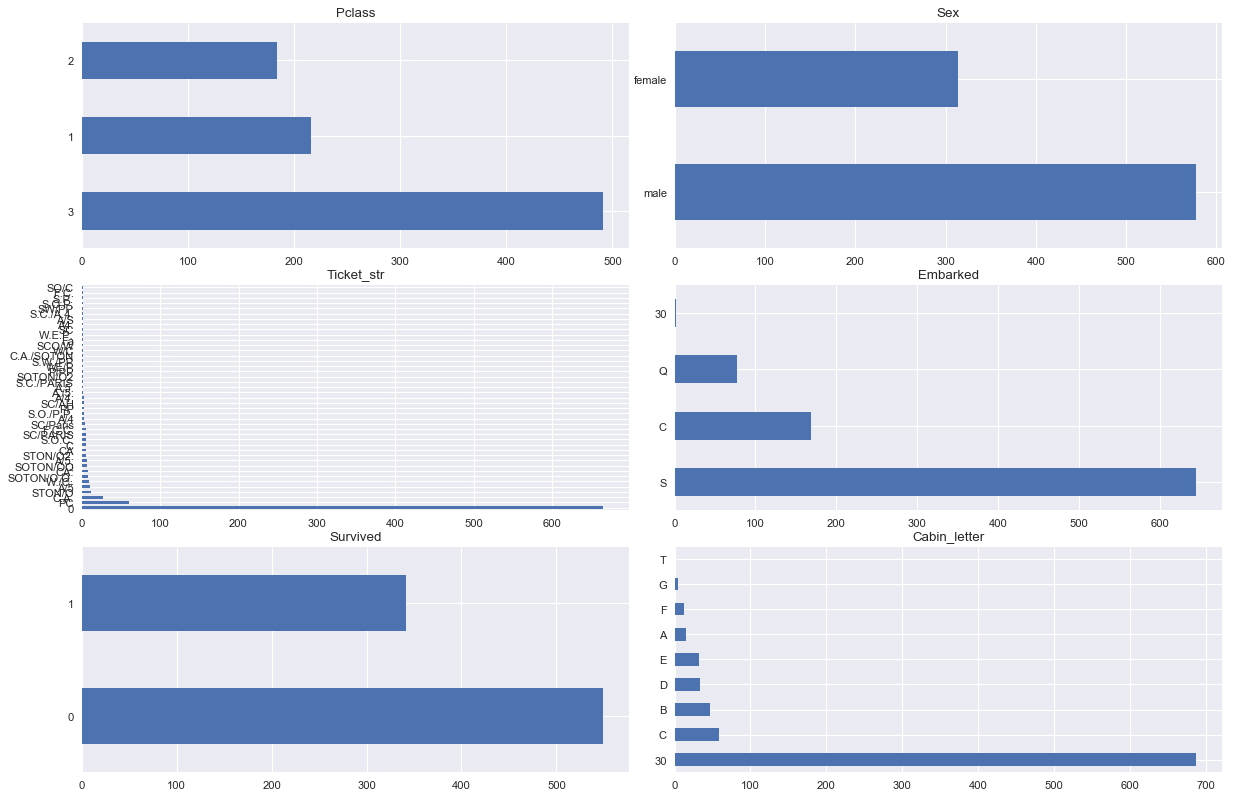

In [8]:
discrete_1=['Pclass', 'Sex', 'Ticket_str', 'Embarked', 'Survived', 'Cabin_letter']

fig1, axs1 = plt.subplots(3,2, figsize=(15,10),dpi=80, squeeze=False)
fig1.tight_layout()
for ax1,n in zip(axs1, range(3)):    
    for i in range(2*n, 2*(n+1)):
        column=discrete_1[i]
        ax1[i%2].set_title(column)
        y=df[column].value_counts()
        y.plot.barh(ax=ax1[i%2])


**Correlation analysis, continuous variables**

- Age: Very interesting trends! It seems there's much more missing age values among those that didn't make it, and children dispropotionately survived -> need to create a categorical "age missing" variable
- Fare: as expected, low fares died at higher rates
- SibSp: those with families (2+) survived disproportionately
- Parch: those with parents (kids) survived at higher rates
- Ticket_number: those with low/missing ticketn numbers survived at higher rates -> categorical variable?
- Cabin_number: those who survived often had missing cabin numbers (maybe cabin numbers assigned more to lower classes)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Ticket,Fare,Cabin_number
PassengerId,1.000000,-0.005007,-0.035144,0.033019,-0.057527,-0.001652,-0.026259,0.012658,0.028847
Survived,-0.005007,1.000000,-0.338481,-0.070657,-0.035322,0.081629,-0.115157,0.257307,0.230030
Pclass,-0.035144,-0.338481,1.000000,-0.329727,0.083081,0.018443,0.266662,-0.549500,-0.574774
Age,0.033019,-0.070657,-0.329727,1.000000,-0.232440,-0.180330,-0.115401,0.090632,0.192111
SibSp,-0.057527,-0.035322,0.083081,-0.232440,1.000000,0.414838,0.083385,0.159651,-0.037658
Parch,-0.001652,0.081629,0.018443,-0.180330,0.414838,1.000000,-0.002736,0.216225,0.004655
Ticket,-0.026259,-0.115157,0.266662,-0.115401,0.083385,-0.002736,1.000000,-0.142922,-0.137509
Fare,0.012658,0.257307,-0.549500,0.090632,0.159651,0.216225,-0.142922,1.000000,0.410584
Cabin_number,0.028847,0.230030,-0.574774,0.192111,-0.037658,0.004655,-0.137509,0.410584,1.000000


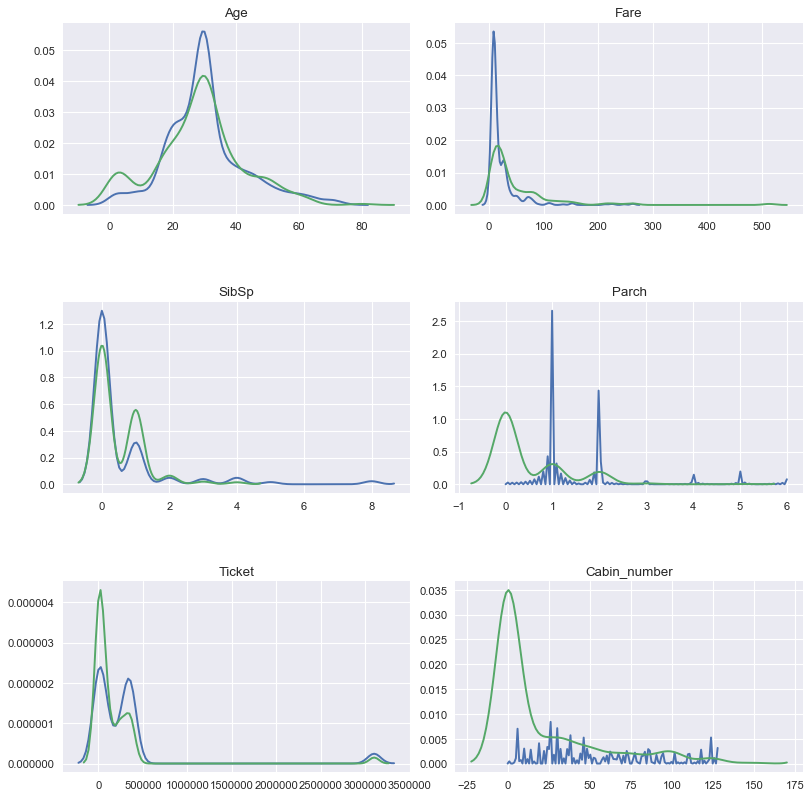

In [9]:
import warnings
warnings.filterwarnings('ignore')

subset_1=df[df['Survived']==1]
subset_0=df[df['Survived']==0]

#Which variables look interesting?
fig1, axs1 = plt.subplots(3,2, figsize=(10,10),dpi=80, squeeze=False)
fig1.tight_layout(h_pad=5.0)

for ax1,i in zip(axs1, range(3)):
    for column, j in zip(continuous[2*i:2*(i+1)], range(2)):
        x0=subset_0[column].values
        x1=subset_1[column].values
        g=sns.distplot(x0,hist=False, norm_hist=False, ax=ax1[j])
        g=sns.distplot(x1,hist=False, ax=ax1[j])
        g.axes.set_title(column)

df.corr()

**Correlation analysis**
-Ticket_str can be reduced to categorical exists/doesn't exist (missing at lower rates for survivors). Probably capturing other information like SES
- Sex is interesting: women survived at much higher rates than men
- Embarked - clear relationship; those who embarked at Q much less likely to survive. Is this a wealth effect?
- Cabin letter has a strong effect

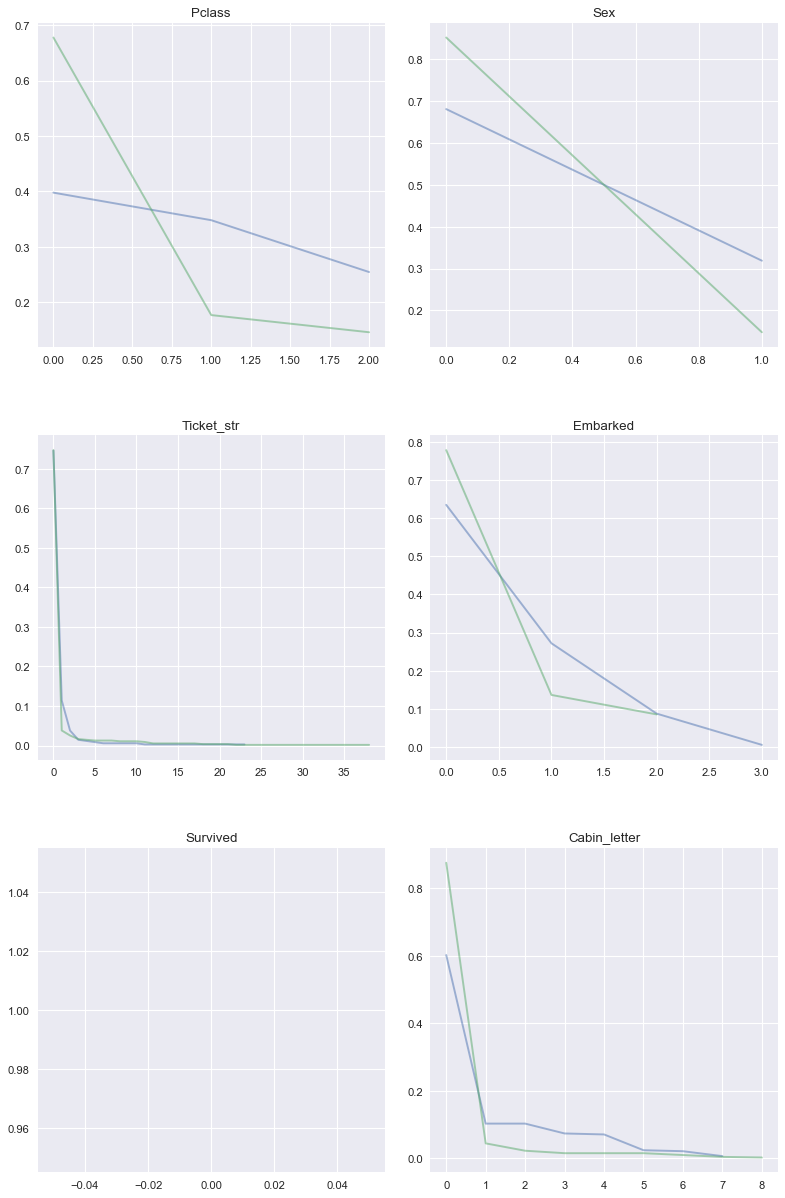

In [10]:
subset_0=df[discrete_1][df['Survived']==0]
subset_1=df[discrete_1][df['Survived']==1]

fig1, axs1 = plt.subplots(3,2, figsize=(10,15),dpi=80, squeeze=False)
fig1.tight_layout(h_pad=5.0)
for ax1,i in zip(axs1, range(3)):
    for k in range(2):
        column=discrete_1[2*i+k]
        y0=subset_0[column].value_counts()/len(subset_0)
        x0=range(len(subset_0[column].unique()))
        x1=range(len(subset_1[column].unique()))
        x_vals=subset_1[column].unique()
        y1=subset_1[column].value_counts()/len(subset_1)
        axis=ax1[k]
        axis.plot(x1,y1, alpha=0.5)
        axis.plot(x0,y0, alpha=0.5)
        axis.set_title(column)
        

In [11]:
def sumTable_cat(string, cutoff):
    x=df[[string, 'Survived']].groupby([string])
    summ=pd.concat([x.sum()/x.count(), x.count()], axis=1)
    summ.columns=['% Survived', 'count']
    print(summ[summ.iloc[:,0]>cutoff], '\n')

sumTable_cat('Sex', 0)
sumTable_cat('Cabin_letter',0)

        % Survived  count
Sex                      
female    0.742038    314
male      0.188908    577 

              % Survived  count
Cabin_letter                   
30              0.299854    687
A               0.466667     15
B               0.744681     47
C               0.593220     59
D               0.757576     33
E               0.750000     32
F               0.615385     13
G               0.500000      4 



**Feature engineering**
- Creating a categorical variable if a cabin letter is present or not (don't seem significantly different)
- Categorical variable if a Ticket_str is present or not


In [13]:
# Create Mr/Mrs variables - using Ahmed Besbes' code
def get_titles():
    global df
    # we extract the title from each name
    df['Title'] = df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"
                        }
    # we map each title
    df['Title'] = df.Title.map(Title_Dictionary)
get_titles()


In [14]:
#Remove certain values, create present/not present ticket string variable
df.ix[(df.Cabin_letter == 'T'),
      'Cabin_letter']='Missing'

df.ix[(df.Ticket_str != 0),
      'Ticket_str']='Present'
df.ix[(df.Ticket_str != 'Present'),
      'Ticket_str']='Not Present'

In [15]:
# Set variables to string, mean value imputation for missing features

df['Pclass'].apply(str)
df['Cabin_letter'].apply(str)
df['Embarked'].apply(str)
df['Embarked'][df['Embarked']==30]='Q'
df['Cabin_letter'][df['Cabin_letter']==30]='Missing'

**Building a random forest model**
- Problem: the effects don't look linear. Logit regression wouldn't properly interpret this, we're going to try random forest (decision tree could overfit, especially for such a small dataset)

In [20]:
discrete_feat=['Pclass', 'Sex', 'Embarked', 'Cabin_letter', 'Title']
continuous_feat=['Age', 'Fare', 'SibSp', 'Parch', 'Ticket', 'Cabin_number']
predict=['Survived']

In [25]:
#Preprocessing - k binary encoding

from scipy.sparse import csr_matrix
from sklearn import preprocessing
df_encoded=df[discrete_feat].apply(preprocessing.LabelEncoder().fit_transform)
df_encoder=preprocessing.OneHotEncoder()
df_encoder.fit(df_encoded)
dis=df_encoder.transform(df_encoded)
discrete=dis.todense()

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

ranFor = RandomForestClassifier(n_estimators=100, bootstrap=False, criterion='entropy',min_samples_leaf=5, min_samples_split=10)
x_train=np.concatenate([discrete, df[continuous_feat].values], axis=1)
X=x_train
y=df[predict].values.ravel()
ranFor.fit(X,y)

expected=y
predicted=ranFor.predict(X)

In [26]:
#test on training set
expected=y
predicted=ranFor.predict(X)

from sklearn import metrics

score_train = metrics.f1_score(y, predicted)
pscore_train = metrics.accuracy_score(y, predicted)
recscore_train = metrics.recall_score(y, predicted)
matrix_train=metrics.confusion_matrix(y, predicted)

print('train recall score:', recscore_train)
print('train precision score:', pscore_train)
print('train f1:',score_train)
print('train confusion matrix: \n', matrix_train)

train recall score: 0.80701754386
train precision score: 0.897867564534
train f1: 0.858475894246
train confusion matrix: 
 [[524  25]
 [ 66 276]]


** Testing our model **

In [27]:
#Test data processing
ticket_tuples_test=df_test['Ticket'].str.split(' ')
digits_test=pd.Series(ticket_tuples_test.str[1])
string_test=pd.Series(ticket_tuples_test.str[0])

for i in range(0,digits_test.shape[0]):
    if(digits_test[i]!=digits_test[i]):
        digits_test[i]=string_test[i]
        string_test[i]=0
    if(digits_test[i]=="LINE"):
        digits_test[i]=0
    if(digits_test[i]=="Basle"):
        digits_test[i]=0

df_test['Ticket']=pd.to_numeric(digits_test)
df_test['Ticket_str']=string_test

df_test['Cabin_letter']=df_test['Cabin'].str.slice(0,1)
df_test['Cabin_number']=df_test['Cabin'].str.slice(1)

ticket_tuples_test=df_test['Cabin'].str.split(' ')
subset_test=pd.Series(ticket_tuples_test.str[1])
subset2_test=subset_test.str.slice(start=1)
sub_test=df_test.loc[subset2_test.notnull()]
sub3_test=np.transpose(np.array([subset2_test.isnull()]))

for n in range(sub3_test.shape[0]):
    if (not sub3_test[n]):
        df_test['Cabin_number'][n]=subset2_test[n]

df_test['Cabin_number']=df_test['Cabin_number'].fillna(0)

for n in range(df_test['Cabin_number'].shape[0]):
    value_test=df_test['Cabin_number'][n]
    try:
        value_test = int(value_test)
    except ValueError:
        df_test['Cabin_number'][n]=0

df_test['Cabin_number']=df_test['Cabin_number'].astype(int)
df_test=df_test.fillna(30);


def get_titles():
    global df_test
    # we extract the title from each name
    df_test['Title'] = df_test['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"
                        }
    # we map each title
    df_test['Title'] = df_test.Title.map(Title_Dictionary)

get_titles()    

df_test.ix[(df_test.Ticket_str != 0),
      'Ticket_str']='Present'
df_test.ix[(df_test.Ticket_str != 'Present'),
      'Ticket_str']='Not Present'

df_test['Pclass'].apply(str)
df_test['Cabin_letter'].apply(str)
df_test['Embarked'].apply(str)
df_test['Embarked'][df_test['Embarked']==30]='Missing'
df_test['Cabin_letter'][df_test['Cabin_letter']==30]='Missing'

In [28]:
#Set up variables for validity test
df_encoded_test=df_test[discrete_feat].apply(preprocessing.LabelEncoder().fit_transform)
df_encoder_test=preprocessing.OneHotEncoder()
df_encoder_test.fit(df_encoded_test)
dis_test=df_encoder_test.transform(df_encoded_test)
discrete_test=dis_test.todense()

x_test=np.concatenate([discrete_test, df_test[continuous_feat].values], axis=1)
X_test=x_test
predicted_test=ranFor.predict(X_test)


In [29]:
survived=predicted_test
passengerid=df_test['PassengerId'].values
output = {'Survived':predicted_test}

df_output=pd.DataFrame(data=output, index=passengerid, columns=['Survived'])
df_output.index.name='PassengerId'
df_output.to_csv('C:/Users/Baptiste/Documents/Python Scripts/output.csv')

**Feature importance **

In [31]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X, y)

features = pd.DataFrame()
features['feature'] = 
features['importance'] = clf.feature_importances_

features.sort(['importance'],ascending=False)

[[  0.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    2.11710000e+04   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    1.75990000e+04   8.50000000e+01]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    3.10128200e+06   0.00000000e+00]
 ..., 
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   2.00000000e+00
    6.60700000e+03   0.00000000e+00]
 [  1.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    1.11369000e+05   1.48000000e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00 ...,   0.00000000e+00
    3.70376000e+05   0.00000000e+00]]


AttributeError: 'matrix' object has no attribute 'columns'